#### Import Necessary Dependencies

In [4]:
%pip install -q datasets

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

#### Load the dataset

In [6]:
ds = pd.read_csv('/content/EcoPreprocessed.csv')

#### Perform EDA

##### Number of columns and tuples

In [7]:
tuples, columns = ds.shape
print(f'Number of Records: {tuples}\nNumber of features: {columns}')

Number of Records: 4084
Number of features: 4


##### Count of Null values

In [8]:
ds.isnull().sum() # no null value found

Unnamed: 0    0
review        0
polarity      0
division      0
dtype: int64

##### Distribution of the

<Axes: >

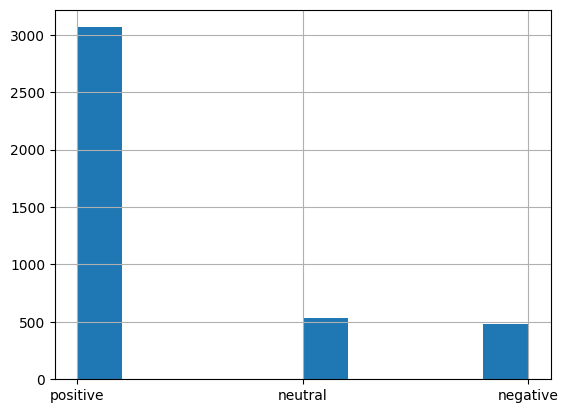

In [9]:
import matplotlib.pyplot as plt
ds['division'].hist()

Comment: As we can see above the database is highly biased

#### Utility objects and functions

In [10]:
labelencoder = LabelEncoder()

#### Preprocessing

##### Drop unnecessary columns

In [11]:
ds = ds.drop('Unnamed: 0', axis=1) # dropped Unnamed: 0
ds = ds.drop('polarity', axis=1) # dropped polarity
ds

,review,division
0,able play youtube alexa,positive
1,able recognize indian accent really well drop ...,positive
2,absolute smart device amazon connect external ...,positive
3,absolutely amaze new member family control hom...,positive
4,absolutely amaze previously sceptical invest m...,positive
...,...,...
4079,yo yo yo love go if want one smart speaker val...,positive
4080,youtube music,neutral
4081,youtube support nahi kartasong recognise achha...,neutral
4082,yup proscontrols wipro light amazinglysony bra...,neutral


#### Encode labels accordingly

In [12]:

ds['division'] = labelencoder.fit_transform(ds['division'])
results = labelencoder.classes_

In [61]:
results

array(['negative', 'neutral', 'positive'], dtype=object)

In [13]:
ds.head()

,review,division
0,able play youtube alexa,2
1,able recognize indian accent really well drop ...,2
2,absolute smart device amazon connect external ...,2
3,absolutely amaze new member family control hom...,2
4,absolutely amaze previously sceptical invest m...,2


#### Create Huggingface Datasets

In [14]:
hds = Dataset.from_pandas(ds)
hds

Dataset({
    features: ['review', 'division'],
    num_rows: 4084
})

In [15]:
hds = hds.train_test_split(test_size=0.2, shuffle=True, seed=42)

In [16]:
hds

DatasetDict({
    train: Dataset({
        features: ['review', 'division'],
        num_rows: 3267
    })
    test: Dataset({
        features: ['review', 'division'],
        num_rows: 817
    })
})

#### Fine tune the huggingface/setfit transformer based sentiment classifier

In [17]:
# %pip install -q setfit sentence_transformers # uncomment to download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.3 MB/s eta 0:00:00


In [18]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset

In [19]:
train_dataset = sample_dataset(hds['train'], label_column="division", num_samples=8)
eval_dataset = hds['test']

#### Get the base model

In [20]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [43]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=10, # The number of epochs to use for contrastive learning
    column_mapping={"review": "text", "division": "label"} # Map dataset columns to text/label expected by trainer
)

In [53]:
trainer.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 960
  Num epochs = 10
  Total optimization steps = 600
  Total train batch size = 16


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

In [54]:
metrics = trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


In [60]:
metrics

{'accuracy': 0.6719706242350061}

In [57]:
# from huggingface_hub import notebook_login

# notebook_login()

In [59]:
trainer.push_to_hub("AmitPress/bestsenti", )

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model_head.pkl:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/AmitPress/bestsenti/tree/main/'